In this lab you will do the following steps in order:

1. Load a new dataset using ``torchvision dataloader``
2. Perform transfer learning of a pre-trained NN (Neural Network)





Useful resources:

* [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)






Use GPU if available

In [1]:
import torch
import glob  # Import library for finding all files matching a pattern
from PIL import Image  # Import library for image processing
import numpy as np  # Import library for numerical operations (not used here)
import os  # Import library for operating system functionalities
from tqdm import tqdm  # Import library for displaying progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Data preparation

In [2]:
# #download images
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
# #download metadata
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
# #extract
# !tar -xf imdb_crop.tar
# !tar -xf imdb_meta.tar

In [3]:
# # move to data folder
# !mv imdb/ data/
# !mv imdb_crop/ data/

Remove grayscale images

In [4]:
# # Define a path pattern to search for all jpg images within subdirectories of "data/imdb_crop"
# image_path_pattern = "data/imdb_crop/*/*.jpg"

# # Find all image file paths matching the pattern
# image_paths = glob.glob(image_path_pattern)

# imgs_removed = 0
# # Iterate through each image path
# for image_path in tqdm(image_paths):
#   # Open the image using Pillow's Image class
#   image = Image.open(image_path)

#   # Get the number of color channels in the image (e.g., RGB has 3 channels)
#   num_channels = len(image.getbands())

#   # Check if the image has a different number of channels than expected (likely grayscale or unsupported format)
#   if num_channels != 3:
#     # If not 3 channels, remove the image file
#     os.remove(image_path)
#     # print(f"Removed {image_path} (not RGB format)")  # Print statement to show removed files
#     imgs_removed += 1

# print(f"Removed {imgs_removed} images") ### --> Removed 22532 images

Define function to convert numeric date to common date format

In [5]:
from datetime import datetime, timedelta  # Import libraries for date and time manipulation

def datenum_to_datetime(datenum):
  """
  Converts a date represented as a floating-point number (Excel-style) to a Python datetime object.

  Args:
      datenum (float): The date represented as a floating-point number.

  Returns:
      datetime: The converted datetime object (year only if conversion fails).
          If conversion fails due to ValueError, TypeError, or OverflowError,
          returns np.nan.
  """

  try:
    # Extract components from the datenum
    days = datenum % 1  # Extract days (decimal part)
    hours = days % 1 * 24  # Extract hours from remaining decimal part
    minutes = hours % 1 * 60  # Extract minutes from remaining decimal part
    seconds = minutes % 1 * 60  # Extract seconds from remaining decimal part

    # Convert to datetime object with separate day, hour, minute, and second components
    exact_date = (datetime.fromordinal(int(datenum))  # Convert integer part to date
                 + timedelta(days=int(days))  # Add extracted days
                 + timedelta(hours=int(hours))  # Add extracted hours
                 + timedelta(minutes=int(minutes))  # Add extracted minutes
                 + timedelta(seconds=round(seconds)))  # Add extracted seconds (rounded)

    # Adjust for Excel's epoch being different from standard epoch (correct for year)
    exact_date -= timedelta(days=366)

    # Return the year from the converted datetime object
    return exact_date.year

  except (ValueError, TypeError, OverflowError) as e:
    return np.nan  # Return np.nan if conversion fails


Define the [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy
import torch
import collections

class FacesDataset(Dataset):
      """Face Landmarks dataset.

      This class loads and preprocesses a dataset of face images with corresponding ages.
      It supports train, validation, and test splits.
      """

      def __init__(self, root_dir, transform, split):
        """
        Args:
            root_dir (string): Directory containing the images.
            transform (callable, optional): Transformation to be applied to the images.
            split (string): Split type ("train", "val", or "test").
        """
        self.split=split
        self.root_dir = root_dir
        self.data = self.get_data()  # Load and preprocess data
        total_data_len = int(len(self.data) * 0.5)  # Select small portion of the dataset

        # Randomly shuffle indices for train/val/test split
        idx = np.arange(total_data_len)
        np.random.seed(0)
        np.random.shuffle(idx)
        print(f"Shuffled indices (first 5): {idx[:5]}")  # Print first 5 shuffled indices

        # Select data based on split
        if split == "train":
            self.data = self.data[idx[:int(total_data_len * 0.6)]]
            print(split, ' indexes ', idx[:int(total_data_len * 0.6)])
        elif split == "val":
            self.data = self.data[idx[int(total_data_len * 0.6):int(total_data_len * 0.8)]]
            print(split, ' indexes ', idx[int(total_data_len * 0.6):int(total_data_len * 0.8)])
        else:
            self.data = self.data[idx[int(total_data_len * 0.8):]]
            print(split, ' indexes ', idx[int(total_data_len * 0.8):])

        # Analyze age distribution (uncomment to print)
        # age_distribution = collections.Counter()
        # for i, sample in enumerate(self.data):
        #     age_distribution[sample[1]] += 1
        # print(age_distribution)  # Uncomment to print the Counter object


        self.transform = transform



      def get_data(self):
        """
        Loads and preprocesses data from the IMDB dataset (.MAT file).

        This function performs the following steps:
            1. Loads data from the MAT file using scipy.io.loadmat.
            2. Defines column names for the loaded data.
            3. Converts the loaded data into a dictionary.
            4. Creates a pandas DataFrame for efficient data manipulation.
            5. Prints DataFrame shape and the first few rows (before processing).
            6. Converts date of birth to age using vectorized operations.
            7. Filters images based on face score and presence of a single face.
                - Removes images without a face (face_score != -np.inf).
                - Ensures only one face is present (second_face_score.isna()).
                - Filters based on minimum face score threshold (face_score >= 3.5).
                - Filters for valid age range (0 <= age <= 100).
                - Converts age to integer and drops unnecessary columns.
            8. Constructs full image paths by prepending the root directory.
            9. Filters for images with existing paths using vectorized boolean indexing.
            10. Prints DataFrame shape and the first few rows (after processing).
            11. Returns the preprocessed data as a NumPy array.
        """

        # Load data from MAT file and define column names
        mat_imdb = scipy.io.loadmat('data/imdb/imdb.mat')
        columns = ["full_path", "dob", "photo_taken", "second_face_score", "face_score"]

        # Convert loaded data into a dictionary
        data_dict = {col: mat_imdb['imdb'][0][0][col][0] for col in columns}

        # Create pandas DataFrame for efficient data manipulation
        df_imdb = pd.DataFrame(data_dict)
        if self.split=="train":
          print("Before processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows 

        # Convert date of birth to age using vectorized operations
        df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)
        df_imdb['age'] = df_imdb['photo_taken'].sub(df_imdb['date_of_birth'])  # Handle potential NaNs

        # Filter images based on face score and presence of a single face
        df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]  # Remove images without a face
        df_imdb = df_imdb[df_imdb['second_face_score'].isna()]  # Ensure only one face is present
        df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]  # Filter based on minimum face score threshold
        df_imdb = df_imdb[(df_imdb['age'] <= 100) & (df_imdb['age'] >= 0)]  # Filter for valid age range
        df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))  # Convert age to integer
        df_imdb = df_imdb.drop(columns=['date_of_birth', 'dob', 'photo_taken', "second_face_score", "face_score"])  # Remove unnecessary columns

        print(self.root_dir)
        # Construct full image paths using vectorized operations
        df_imdb['full_path'] = self.root_dir+"/"+ df_imdb['full_path'].apply(lambda x: x[0])

        # Filter for images with existing paths using vectorized boolean indexing
        df_imdb = df_imdb[df_imdb['full_path'].apply(os.path.exists)]

        if self.split=="train":
          print("After processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        return df_imdb.to_numpy()  # Return preprocessed data as a NumPy array

      def __len__(self):
        """
        Returns the length of the dataset (number of samples).

        This method overrides the default behavior of `len` for the dataset object.
        It simply returns the length of the internal `data` list, which represents
        the preprocessed data after loading and filtering.
        """
        return len(self.data)

      def __getitem__(self, idx):
        """
        Retrieves a sample (image and corresponding age) at a given index.

        This method overrides the default behavior of indexing for the dataset object.
        It takes an index `idx` and performs the following:
            1. Accesses the image name and age at the specified index from `self.data`.
            2. Opens the image using `Image.open` with the full path constructed by
               combining `self.root_dir` and `img_name`.
            3. Applies the defined transformation (`self.transform`) to the image.
            4. Normalizes the age by dividing by 100.
            5. Creates a dictionary `sample` containing the preprocessed image (`image`)
               and the normalized age as a PyTorch tensor (`torch.tensor(age).float()`).
            6. Returns the constructed `sample` dictionary.
        """
        img_name, age = self.data[idx]
        # image = Image.open(os.path.join(self.root_dir, img_name))
        image = Image.open(os.path.join(img_name))
        image = self.transform(image)
        age = age / 100

        sample = {'image': image, 'age': torch.tensor(age).float()}
        return sample

Build the train/val/test dataloaders




In [7]:
import pickle

# Define data transformations (augmentations for training and normalization)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 32

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("data/imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("data/imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("data/imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")


Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
data/imdb_crop
After processing:
(71828, 2)
                                            full_path  age
7   data/imdb_crop/02/nm0000002_rm1363385088_1924-...   80
15  data/imdb_crop/02/nm0000002_rm2585828096_1924-...   82
18  data/imdb_crop/02/nm0000002_rm2769394176_1924-...   82
19  data/imdb_crop/02/n

In [8]:
!pwd
!ls
!ls data/
!ls data/imdb/

/home/andrea/unimib/Supervised/00_exercises/lab_06


data	       imdb_meta.tar			       models
imdb_crop.tar  lab_06_CNN_transfer_learning_all.ipynb
imdb  imdb_crop
imdb.mat


2. Define a Neural Network (NN) [Mobilenet](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2) pretrained on Imagenet.

Replace the last classifier

In [9]:
import torchvision
import torch.nn as nn

# Define the model architecture (MobileNetV2)
net = torchvision.models.resnet18(weights='IMAGENET1K_V1')  # Load pre-trained weights
net_name = net.__class__.__name__ + '18' # Get the name of the network class
print(net_name)

print(net)

# MObileNetV2
# # Adjust the final classification layer
# num_ftrs = net.classifier[1].in_features  # Get the number of input features for the last layer
# net.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(512, 32),  # Second linear layer with 32 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
# )

# ResNet18
# Adjust the final classification layer
num_ftrs = net.fc.in_features  # Get the number of input features for the last layer
print(num_ftrs)
net.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
    nn.GELU(),  # GELU activation function
    nn.Linear(512, 32),  # Second linear layer with 32 units
    nn.GELU(),  # GELU activation function
    nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
)

# Move the model to the appropriate device (CPU or GPU)
net.to(device)

ResNet18
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
from torchsummary import summary
# Print model summary
summary(net, (3, 256, 256))  # Input shape (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

**Transfer learning**

Train only the last layers

In [11]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)

Unfreezing layer: conv1, Parameter shape: torch.Size([64, 3, 7, 7])
Unfreezing layer: bn1, Parameter shape: torch.Size([64])
Unfreezing layer: bn1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64, 64, 3, 3])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64, 64, 3, 3])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64, 64, 3, 3])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64, 64, 3, 3])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer1, Parameter shape: torch.Size([64])
Unfreezing layer: layer2, Parameter shape: torch.Size([128

Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [12]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 10  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler


**Fine-tuning**

Train the network on the training data performing a validation at the end of each epoch. The evaluation is done using [PLCC](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [SROCC](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

1, [67, 674] loss: 0.1226	PLCC: 0.111	SROCC: 0.165	lr: 0.001000
1, [134, 674] loss: 0.0937	PLCC: 0.386	SROCC: 0.341	lr: 0.000999
1, [201, 674] loss: 0.0882	PLCC: 0.497	SROCC: 0.454	lr: 0.000998
1, [268, 674] loss: 0.0867	PLCC: 0.507	SROCC: 0.488	lr: 0.000996
1, [335, 674] loss: 0.0803	PLCC: 0.609	SROCC: 0.585	lr: 0.000994
1, [402, 674] loss: 0.0808	PLCC: 0.609	SROCC: 0.585	lr: 0.000991
1, [469, 674] loss: 0.0782	PLCC: 0.643	SROCC: 0.615	lr: 0.000988
1, [536, 674] loss: 0.0782	PLCC: 0.645	SROCC: 0.616	lr: 0.000985
1, [603, 674] loss: 0.0748	PLCC: 0.664	SROCC: 0.626	lr: 0.000981
1, [670, 674] loss: 0.0765	PLCC: 0.657	SROCC: 0.638	lr: 0.000976
Validation loss: 0.080338	PLCC: 0.657	SROCC: 0.654


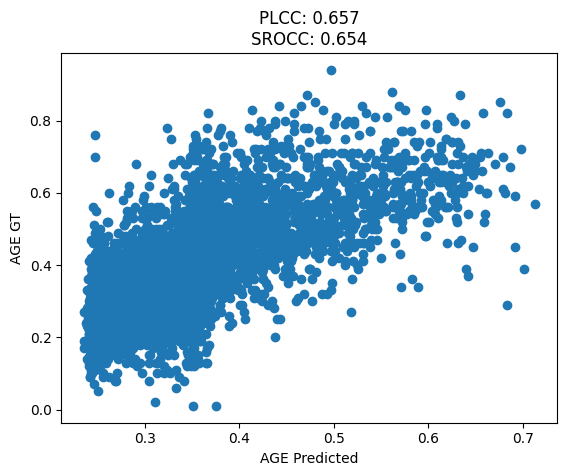

2, [67, 674] loss: 0.0735	PLCC: 0.692	SROCC: 0.650	lr: 0.000971
2, [134, 674] loss: 0.0696	PLCC: 0.716	SROCC: 0.691	lr: 0.000965
2, [201, 674] loss: 0.0716	PLCC: 0.719	SROCC: 0.694	lr: 0.000959
2, [268, 674] loss: 0.0697	PLCC: 0.722	SROCC: 0.699	lr: 0.000953
2, [335, 674] loss: 0.0681	PLCC: 0.727	SROCC: 0.694	lr: 0.000946
2, [402, 674] loss: 0.0679	PLCC: 0.734	SROCC: 0.722	lr: 0.000939
2, [469, 674] loss: 0.0662	PLCC: 0.729	SROCC: 0.708	lr: 0.000931
2, [536, 674] loss: 0.0698	PLCC: 0.727	SROCC: 0.706	lr: 0.000923
2, [603, 674] loss: 0.0660	PLCC: 0.746	SROCC: 0.734	lr: 0.000915
2, [670, 674] loss: 0.0664	PLCC: 0.735	SROCC: 0.726	lr: 0.000906
Validation loss: 0.065899	PLCC: 0.744	SROCC: 0.731


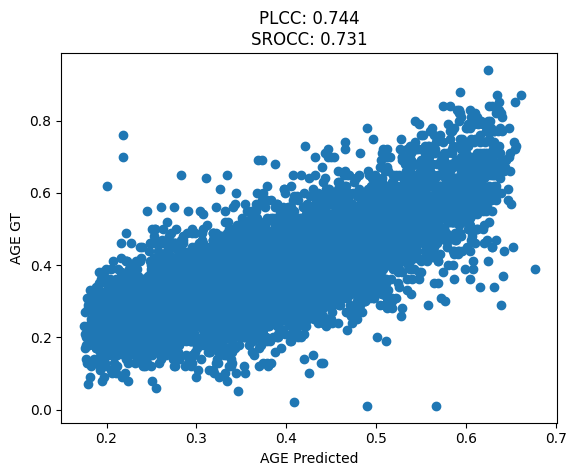

3, [67, 674] loss: 0.0664	PLCC: 0.747	SROCC: 0.732	lr: 0.000896
3, [134, 674] loss: 0.0651	PLCC: 0.754	SROCC: 0.742	lr: 0.000887
3, [201, 674] loss: 0.0640	PLCC: 0.758	SROCC: 0.746	lr: 0.000876
3, [268, 674] loss: 0.0648	PLCC: 0.778	SROCC: 0.764	lr: 0.000866
3, [335, 674] loss: 0.0651	PLCC: 0.757	SROCC: 0.735	lr: 0.000855
3, [402, 674] loss: 0.0638	PLCC: 0.755	SROCC: 0.745	lr: 0.000844
3, [469, 674] loss: 0.0632	PLCC: 0.773	SROCC: 0.753	lr: 0.000833
3, [536, 674] loss: 0.0638	PLCC: 0.772	SROCC: 0.750	lr: 0.000821
3, [603, 674] loss: 0.0641	PLCC: 0.756	SROCC: 0.743	lr: 0.000809
3, [670, 674] loss: 0.0621	PLCC: 0.781	SROCC: 0.772	lr: 0.000797
Validation loss: 0.100355	PLCC: 0.750	SROCC: 0.724


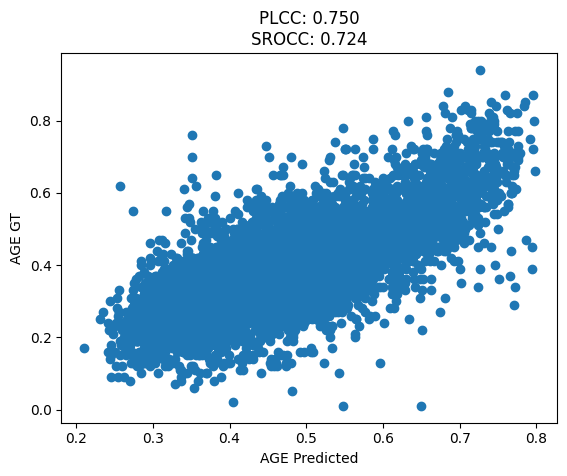

4, [67, 674] loss: 0.0604	PLCC: 0.785	SROCC: 0.779	lr: 0.000783
4, [134, 674] loss: 0.0592	PLCC: 0.797	SROCC: 0.782	lr: 0.000770
4, [201, 674] loss: 0.0628	PLCC: 0.762	SROCC: 0.763	lr: 0.000757
4, [268, 674] loss: 0.0596	PLCC: 0.793	SROCC: 0.777	lr: 0.000744
4, [335, 674] loss: 0.0607	PLCC: 0.792	SROCC: 0.782	lr: 0.000730
4, [402, 674] loss: 0.0594	PLCC: 0.799	SROCC: 0.779	lr: 0.000716
4, [469, 674] loss: 0.0596	PLCC: 0.809	SROCC: 0.789	lr: 0.000702
4, [536, 674] loss: 0.0609	PLCC: 0.798	SROCC: 0.785	lr: 0.000688
4, [603, 674] loss: 0.0587	PLCC: 0.812	SROCC: 0.802	lr: 0.000673
4, [670, 674] loss: 0.0557	PLCC: 0.809	SROCC: 0.790	lr: 0.000659
Validation loss: 0.062212	PLCC: 0.791	SROCC: 0.772


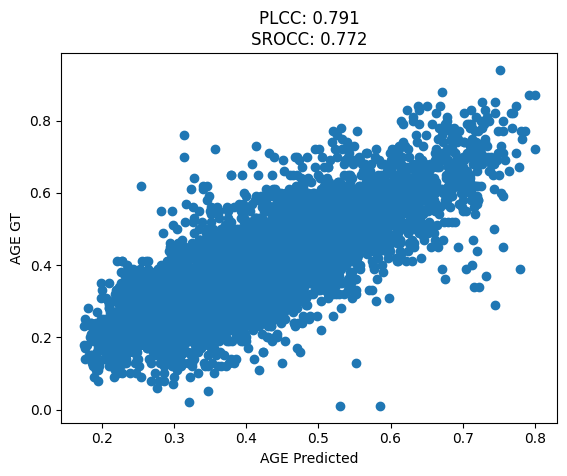

5, [67, 674] loss: 0.0587	PLCC: 0.793	SROCC: 0.795	lr: 0.000643
5, [134, 674] loss: 0.0568	PLCC: 0.810	SROCC: 0.802	lr: 0.000628
5, [201, 674] loss: 0.0554	PLCC: 0.830	SROCC: 0.820	lr: 0.000613
5, [268, 674] loss: 0.0567	PLCC: 0.826	SROCC: 0.815	lr: 0.000598
5, [335, 674] loss: 0.0558	PLCC: 0.820	SROCC: 0.806	lr: 0.000583
5, [402, 674] loss: 0.0565	PLCC: 0.824	SROCC: 0.816	lr: 0.000568
5, [469, 674] loss: 0.0546	PLCC: 0.828	SROCC: 0.804	lr: 0.000552
5, [536, 674] loss: 0.0562	PLCC: 0.817	SROCC: 0.811	lr: 0.000537
5, [603, 674] loss: 0.0550	PLCC: 0.817	SROCC: 0.808	lr: 0.000521
5, [670, 674] loss: 0.0551	PLCC: 0.829	SROCC: 0.810	lr: 0.000506
Validation loss: 0.056278	PLCC: 0.809	SROCC: 0.791


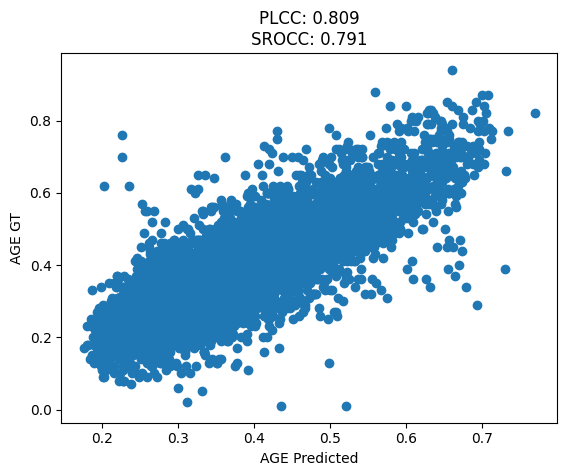

6, [67, 674] loss: 0.0517	PLCC: 0.836	SROCC: 0.828	lr: 0.000490
6, [134, 674] loss: 0.0539	PLCC: 0.836	SROCC: 0.823	lr: 0.000474
6, [201, 674] loss: 0.0516	PLCC: 0.849	SROCC: 0.842	lr: 0.000459
6, [268, 674] loss: 0.0516	PLCC: 0.852	SROCC: 0.840	lr: 0.000443
6, [335, 674] loss: 0.0521	PLCC: 0.843	SROCC: 0.834	lr: 0.000428
6, [402, 674] loss: 0.0506	PLCC: 0.845	SROCC: 0.833	lr: 0.000413
6, [469, 674] loss: 0.0518	PLCC: 0.846	SROCC: 0.834	lr: 0.000398
6, [536, 674] loss: 0.0506	PLCC: 0.846	SROCC: 0.841	lr: 0.000383
6, [603, 674] loss: 0.0506	PLCC: 0.851	SROCC: 0.841	lr: 0.000368
6, [670, 674] loss: 0.0523	PLCC: 0.848	SROCC: 0.837	lr: 0.000353
Validation loss: 0.054120	PLCC: 0.822	SROCC: 0.809


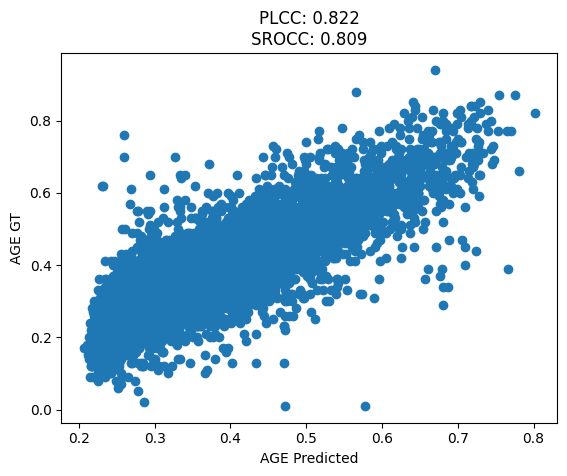

7, [67, 674] loss: 0.0493	PLCC: 0.855	SROCC: 0.849	lr: 0.000337
7, [134, 674] loss: 0.0474	PLCC: 0.868	SROCC: 0.861	lr: 0.000323
7, [201, 674] loss: 0.0479	PLCC: 0.867	SROCC: 0.857	lr: 0.000309
7, [268, 674] loss: 0.0484	PLCC: 0.862	SROCC: 0.856	lr: 0.000295
7, [335, 674] loss: 0.0480	PLCC: 0.868	SROCC: 0.859	lr: 0.000281
7, [402, 674] loss: 0.0466	PLCC: 0.872	SROCC: 0.860	lr: 0.000267
7, [469, 674] loss: 0.0463	PLCC: 0.874	SROCC: 0.869	lr: 0.000254
7, [536, 674] loss: 0.0489	PLCC: 0.855	SROCC: 0.847	lr: 0.000240
7, [603, 674] loss: 0.0476	PLCC: 0.869	SROCC: 0.863	lr: 0.000227
7, [670, 674] loss: 0.0457	PLCC: 0.877	SROCC: 0.867	lr: 0.000215
Validation loss: 0.051702	PLCC: 0.832	SROCC: 0.823


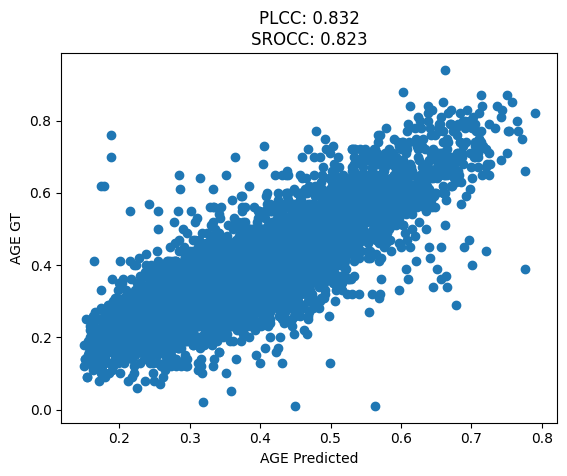

8, [67, 674] loss: 0.0428	PLCC: 0.897	SROCC: 0.883	lr: 0.000202
8, [134, 674] loss: 0.0449	PLCC: 0.873	SROCC: 0.865	lr: 0.000190
8, [201, 674] loss: 0.0449	PLCC: 0.877	SROCC: 0.876	lr: 0.000178
8, [268, 674] loss: 0.0439	PLCC: 0.881	SROCC: 0.874	lr: 0.000166
8, [335, 674] loss: 0.0417	PLCC: 0.890	SROCC: 0.885	lr: 0.000155
8, [402, 674] loss: 0.0452	PLCC: 0.878	SROCC: 0.870	lr: 0.000145
8, [469, 674] loss: 0.0446	PLCC: 0.879	SROCC: 0.874	lr: 0.000134
8, [536, 674] loss: 0.0439	PLCC: 0.894	SROCC: 0.882	lr: 0.000124
8, [603, 674] loss: 0.0424	PLCC: 0.898	SROCC: 0.890	lr: 0.000114
8, [670, 674] loss: 0.0440	PLCC: 0.875	SROCC: 0.872	lr: 0.000105
Validation loss: 0.050520	PLCC: 0.843	SROCC: 0.829


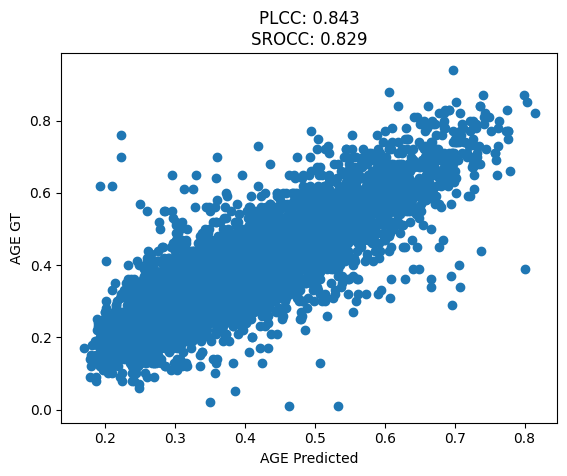

9, [67, 674] loss: 0.0412	PLCC: 0.891	SROCC: 0.891	lr: 0.000096
9, [134, 674] loss: 0.0426	PLCC: 0.888	SROCC: 0.877	lr: 0.000087
9, [201, 674] loss: 0.0410	PLCC: 0.893	SROCC: 0.891	lr: 0.000079
9, [268, 674] loss: 0.0412	PLCC: 0.895	SROCC: 0.889	lr: 0.000071
9, [335, 674] loss: 0.0415	PLCC: 0.901	SROCC: 0.895	lr: 0.000064
9, [402, 674] loss: 0.0387	PLCC: 0.906	SROCC: 0.900	lr: 0.000057
9, [469, 674] loss: 0.0412	PLCC: 0.899	SROCC: 0.895	lr: 0.000051
9, [536, 674] loss: 0.0403	PLCC: 0.907	SROCC: 0.897	lr: 0.000045
9, [603, 674] loss: 0.0392	PLCC: 0.904	SROCC: 0.895	lr: 0.000040
9, [670, 674] loss: 0.0408	PLCC: 0.894	SROCC: 0.886	lr: 0.000035
Validation loss: 0.050018	PLCC: 0.846	SROCC: 0.833


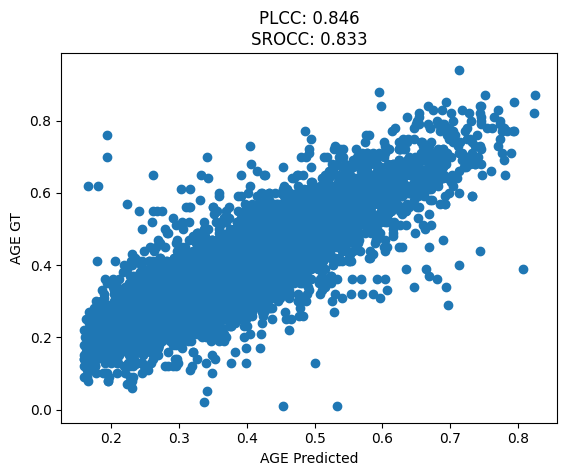

10, [67, 674] loss: 0.0399	PLCC: 0.901	SROCC: 0.895	lr: 0.000030
10, [134, 674] loss: 0.0385	PLCC: 0.915	SROCC: 0.911	lr: 0.000026
10, [201, 674] loss: 0.0394	PLCC: 0.900	SROCC: 0.893	lr: 0.000022
10, [268, 674] loss: 0.0389	PLCC: 0.910	SROCC: 0.905	lr: 0.000019
10, [335, 674] loss: 0.0395	PLCC: 0.905	SROCC: 0.896	lr: 0.000016
10, [402, 674] loss: 0.0378	PLCC: 0.900	SROCC: 0.897	lr: 0.000014
10, [469, 674] loss: 0.0388	PLCC: 0.906	SROCC: 0.901	lr: 0.000012
10, [536, 674] loss: 0.0368	PLCC: 0.912	SROCC: 0.908	lr: 0.000011
10, [603, 674] loss: 0.0397	PLCC: 0.903	SROCC: 0.897	lr: 0.000010
10, [670, 674] loss: 0.0388	PLCC: 0.901	SROCC: 0.895	lr: 0.000010
Validation loss: 0.049268	PLCC: 0.847	SROCC: 0.834


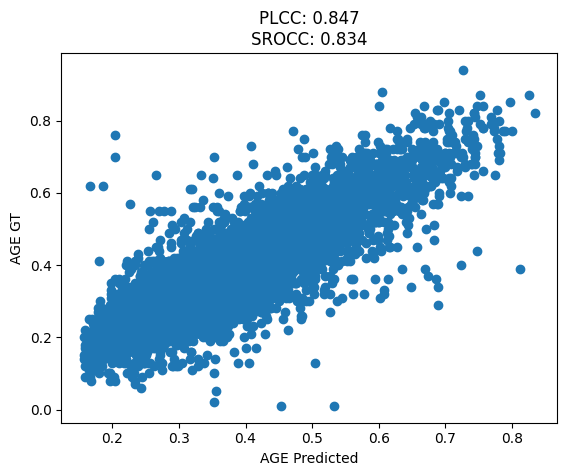

Finished Training


In [13]:

# Training loop
for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    plt.show()

    # Save the model (optional)
    torch.save(net.state_dict(), f"models/{net_name}_fully_unfrozen_epoch_{epoch}.pth")  # Save model state after each epoch

print('Finished Training')


Evaluate on the test-set

Test loss: 0.049840	PLCC: 0.855	SROCC: 0.842


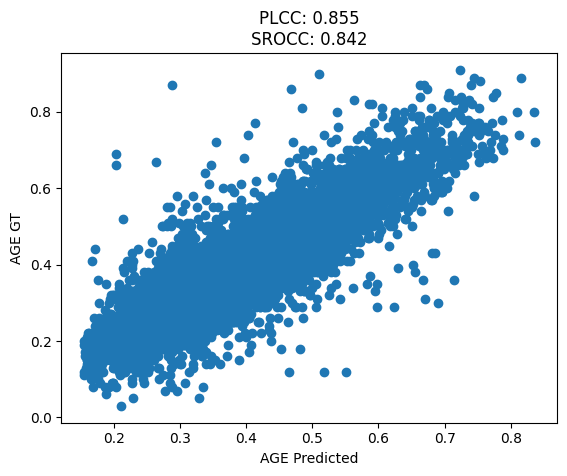

In [14]:
# Testing loop (after training)
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels (predicted age)
pr_labels = []  # List to store predicted labels (model output)

net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

for i, data in enumerate(testloader):
    # Get inputs and labels from the data loader
    inputs, labels = data["image"], data["age"]
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = net(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
    loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
    running_loss.append(loss.item())

# Calculate and print test performance metrics
gt_labels = np.stack(gt_labels)  # Combine ground truth labels
pr_labels = np.stack(pr_labels)  # Combine predictions
s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

# Visualization (optional)
plt.scatter(pr_labels, gt_labels)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
plt.show()


**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).
2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html#classification) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.